In [1]:
import pandas as pd

# utils
import src.utils.visualization.gantt_diagram as gantt
from src.utils.initialization import jobs_jssp_init as init
from src.utils.analysis_basics import check_constraints as check
from src.utils.rolling_process.rolling_filter import *

# solver
from src.solvers.builder import get_job_ops_model_from_dframe
from src.solvers.schedule_converter import get_schedule_dframe
from src.solvers.lp.makespan import solve_jssp_makespan

# data access
from configs.path_manager import get_path

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [2]:
# Harte Abbruchbedingung für die Scheduler
max_time = 60*6     # 6 min


In [3]:
# load file
basic_data_path = get_path("data", "basic")
examples_data_path = get_path("data", "examples")
df_routings = pd.read_csv(basic_data_path / "routings_ft10.csv")
df_routings

,Routing_ID,Operation,Machine,Processing Time
0,0,0,M00,29
1,0,1,M01,78
2,0,2,M02,9
3,0,3,M03,36
4,0,4,M04,49
5,0,5,M05,11
...,...,...,...,...
94,9,4,M08,64
95,9,5,M09,76
96,9,6,M05,47


In [4]:
df_jssp = init.generate_jobs_from_routings(df_routings, shuffle = False)
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,0,0,M00,29
1,J25-0000,0,1,M01,78
2,J25-0000,0,2,M02,9
3,J25-0000,0,3,M03,36
4,J25-0000,0,4,M04,49
5,J25-0000,0,5,M05,11
...,...,...,...,...,...
94,J25-0009,9,4,M08,64
95,J25-0009,9,5,M09,76
96,J25-0009,9,6,M05,47


In [5]:
job_ops = get_job_ops_model_from_dframe(df_jssp)
job_ops

{'J25-0000': [(0, 'M00', 29),
  (1, 'M01', 78),
  (2, 'M02', 9),
  (3, 'M03', 36),
  (4, 'M04', 49),
  (5, 'M05', 11),
  (6, 'M06', 62),
  (7, 'M07', 56),
  (8, 'M08', 44),
  (9, 'M09', 21)],
 'J25-0001': [(0, 'M00', 43),
  (1, 'M02', 90),
  (2, 'M04', 75),
  (3, 'M09', 11),
  (4, 'M03', 69),
  (5, 'M01', 28),
  (6, 'M06', 46),
  (7, 'M05', 46),
  (8, 'M07', 72),
  (9, 'M08', 30)],
 'J25-0002': [(0, 'M01', 91),
  (1, 'M00', 85),
  (2, 'M03', 39),
  (3, 'M02', 74),
  (4, 'M08', 90),
  (5, 'M05', 10),
  (6, 'M07', 12),
  (7, 'M06', 89),
  (8, 'M09', 45),
  (9, 'M04', 33)],
 'J25-0003': [(0, 'M01', 81),
  (1, 'M02', 95),
  (2, 'M00', 71),
  (3, 'M04', 99),
  (4, 'M06', 9),
  (5, 'M08', 52),
  (6, 'M07', 85),
  (7, 'M03', 98),
  (8, 'M09', 22),
  (9, 'M05', 43)],
 'J25-0004': [(0, 'M02', 14),
  (1, 'M00', 6),
  (2, 'M01', 22),
  (3, 'M05', 61),
  (4, 'M03', 26),
  (5, 'M04', 69),
  (6, 'M08', 21),
  (7, 'M07', 49),
  (8, 'M09', 72),
  (9, 'M06', 53)],
 'J25-0005': [(0, 'M02', 84),
  (1, 'M

### a) CBC - COIN-OR Branch and Cut

In [6]:
log_file_path = None # logs_path / "makespan_cbc.log"

# Scheduling
schedule = solve_jssp_makespan(
    job_ops=job_ops,
    solver_type="CBC",
    time_limit=max_time,
    msg=True,
    logPath=log_file_path
)


Solver-Informationen:
  Makespan            : 1041.00
  Solver-Status       : Optimal
  Variablenanzahl     : 551
  Constraintanzahl    : 1000
  Laufzeit            : ~360.35 Sekunden


In [7]:
df_schedule = get_schedule_dframe(schedule)
df_schedule

,Job,Operation,Machine,Start,Processing Time,End
0,J25-0000,0,M00,3.0,29,32.0
1,J25-0000,1,M01,526.0,78,604.0
2,J25-0000,2,M02,717.0,9,726.0
3,J25-0000,3,M03,726.0,36,762.0
4,J25-0000,4,M04,762.0,49,811.0
5,J25-0000,5,M05,811.0,11,822.0
...,...,...,...,...,...,...
94,J25-0009,4,M08,524.0,64,588.0
95,J25-0009,5,M09,591.0,76,667.0
96,J25-0009,6,M05,724.0,47,771.0


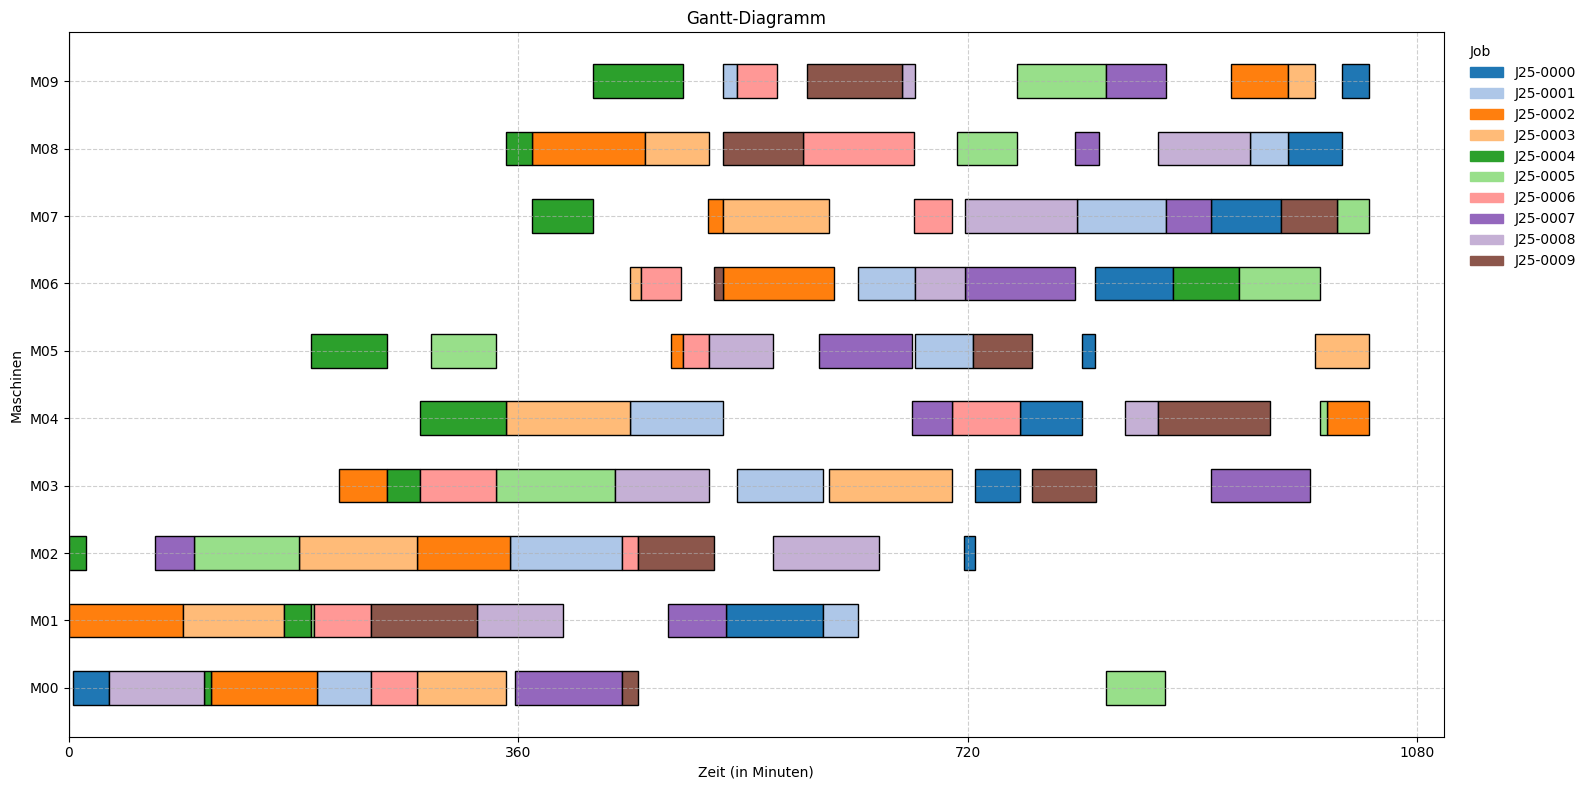

+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Keine Maschinenkonflikte gefunden


True

In [8]:
gantt.get_plot(df_schedule, perspective="Machine")
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_machine_conflict_free(df_schedule)

### b) HiGHS mit PuLP (COIN-OR)
> high performance serial and parallel solver


In [9]:
log_file_path = None # logs_path / "makespan_highs.log"

# Scheduling
schedule = solve_jssp_makespan(
    job_ops=job_ops,
    solver_type="HiGHS",
    time_limit=max_time,
    msg=True,
    logPath=log_file_path
)


Solver-Informationen:
  Makespan            : 950.00
  Solver-Status       : Optimal
  Variablenanzahl     : 551
  Constraintanzahl    : 1000
  Laufzeit            : ~360.08 Sekunden


In [10]:
df_schedule = get_schedule_dframe(schedule)
df_schedule

,Job,Operation,Machine,Start,Processing Time,End
0,J25-0000,0,M00,358.0,29,387.0
1,J25-0000,1,M01,442.0,78,520.0
2,J25-0000,2,M02,528.0,9,537.0
3,J25-0000,3,M03,566.0,36,602.0
4,J25-0000,4,M04,603.0,49,652.0
5,J25-0000,5,M05,664.0,11,675.0
...,...,...,...,...,...,...
94,J25-0009,4,M08,369.0,64,433.0
95,J25-0009,5,M09,541.0,76,617.0
96,J25-0009,6,M05,617.0,47,664.0


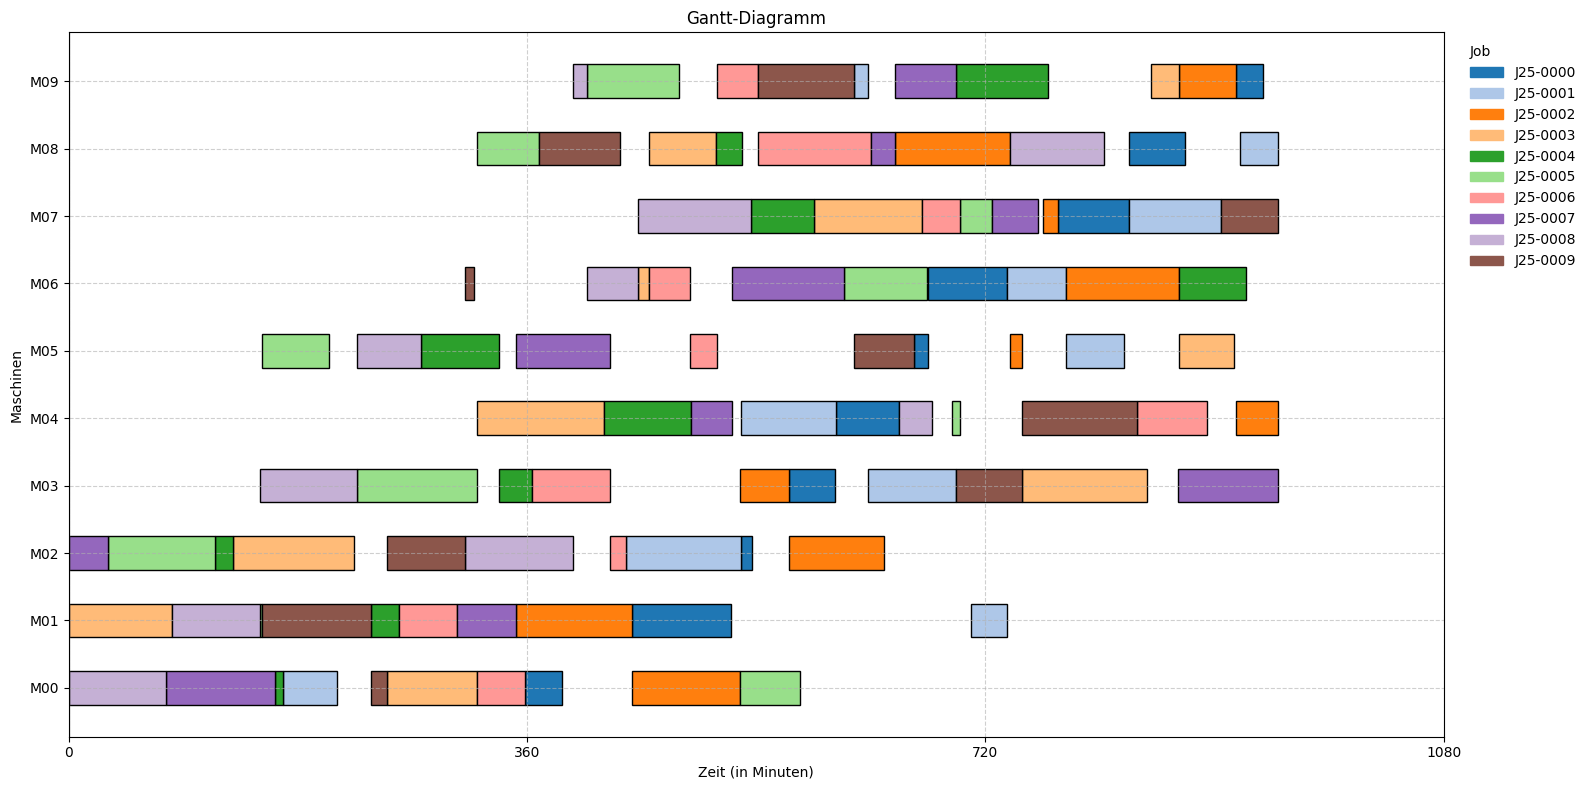

+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Keine Maschinenkonflikte gefunden


True

In [11]:
gantt.get_plot(df_schedule, perspective="Machine")
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_machine_conflict_free(df_schedule)

### c) CP Model (Google OR-Tools)